# Economic Modelling of Execution Tickets

*by Pascal Stichler (from [ephema Labs](https://ephema.io))*

*Shared unter CC BY-SA 4.0*

## Abstract

This is a simulation to estimate the effects of different Execution Ticket mechanism designs.

An introduction of [Execution Tickets](https://ethresear.ch/t/execution-tickets/17944) can be found here
(or a simple introduction [here](https://www.ephema.io/blog/beyond-the-stars-an-introduction-to-execution-tickets-on-ethereum)).


The details of this simulation are outlined in [this research report](https://drive.google.com/drive/u/0/folders/1G9Rln1UL1iOlm5NK4q8ggHr0mF0Zk1r0).

## Implementation Notes

Please note that the packages utils, purchase_functions, models and calc_statistics have to be imported.

Further, note that the base_directory needs to be individually defined.


## Import of Libraries and installation of packages

In [1]:
# Install required packages when first starting up the VM
# always uncomment in first run

!pip install radcad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [2]:
%load_ext autoreload
%autoreload 2 # Automatically reload latest version of modules

import random
import os
import copy
import sys
import scipy.stats as stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from radcad import Model, Simulation, Experiment
import secrets
import warnings



# Connect Google Drive
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

base_directory = userdata.get('secret_base_directory_ETs')
base_file_path = f"{base_directory}/Simulation-Results/"

# Ensure the directory exists
if not base_directory:
    raise ValueError("Base directory not found. Check your userdata settings.")

# Import Support classes
sys.path.append(f"{base_directory}/Support-Classes/")
from utils import *
from purchase_functions import *
from models import Ticket, TicketHolderAgent # self defined in models.py

Mounted at /content/drive


## Running the Simulation

Several params can be manually configured in the *sys_params* setting.

In [3]:
# Define Experiment params
TIMESTEPS = 1000
RUNS = 10 # Results image generation is only supported for 1 run

#  Define System Parameters



sys_params = {
    'selling_mechanism': 'first_price',  # Options 'EIP-1559', 'AMM-style', 'first_price' or 'second_price' currently
    'max_tickets': 100, # For flexible ticket amounts half of this is used as the target
    'initial_ticket_price': 20, # shall be lower than MEV scale as otherwise ticket holders buy tickets at a loss (unrealistic)
    'MEV_scale': 30,
    'slots_per_epoch': 32,
    'number_of_ticket_holders': 10,
    'secondary_market': True, # Decide if secondary market shall be enabled
    'price_vola': {'mean': 0, 'sigma': 0.2}, # Volatility Index. Can be set to [None, None]. If not 'None': defines the mean of the underlying normal distribution (should be set to 0) and sigma being the standard deviation. Typical values might be 0 & 0.2
    'agent_bidding_strategy': 'optimal_heuristic_bidding', # Only relevant for first or second price auctions. Other options: naive_hist_obs_of_dist, hist_obs_of_dist, random_evenly_10_50, optimal_heuristic_bidding (last one only FPA)
    'EIP-1559_max_tickets': 4, # Only relevant for EIP-1559, max. number tickets per slot to be purchased.
    'EIP-1559_adjust_factor': 8, # Defines how fast the price is adjusted for EIP-1559 pricing similar to EIP-1559 (1/factor), 8 = 12.5%
    'AMM_adjust_factor': 25, # Defines how fast the price is adjusted for AMM-style pricing similar to EIP-1559 (1/factor), 8 = 12.5%
    'expiry_period': None, # Define if tickets shall be expire: None - defines non-expiring, otherwise Int of slots to expire. For initialization phase it's ticket_id + expiry_period.
    'reimbursement_factor': None, # Only relevant for AMM-style pricing. Ticket holder can sell their ticket price back to protocol. 'None' for disabling the option. Otherwise a number between 0 and one for the discount (0 is not discount). Note that a too small discount can result in an infinite loop of selling due to discreteness of ticket prices.
}



# If volatility is not set to none, expected volatility is calculated as a baseline

if sys_params['price_vola']['mean'] is not None and sys_params['price_vola']['sigma'] is not None:

    # Calculate the mean of the log-normal distribution manually as existing package has compatibility issues
    mu = float(sys_params['price_vola']['mean'])
    sigma = float(sys_params['price_vola']['sigma'])
    sys_params['expected_vola'] = np.exp(mu + (sigma ** 2) / 2)
else:
    sys_params['expected_vola'] = 1

## Setup Inital State function
def setup_initial_state(params):
  tickets = []
  if params['max_tickets'] > 1:
    tickets = [Ticket(i+1, params) for i in range(params['max_tickets']-1)] # -1 as last ticket will be issued beginning of first slot
  agents = [TicketHolderAgent(i, params) for i in range(params['number_of_ticket_holders'])]
  for ticket in tickets:
      random_agent = random.choice(agents)
      if (params['selling_mechanism'] == 'EIP-1559' or params['selling_mechanism'] == 'AMM-style') and ticket.id % 2 == 0: # for EIP-1559 & AMM mechanism only half of the tickets are assigned
        assign_ticket_to_holder(params['initial_ticket_price'], random_agent, ticket)
      elif (params['selling_mechanism'] != 'EIP-1559' and params['selling_mechanism'] != 'AMM-style'):
        assign_ticket_to_holder(params['initial_ticket_price'], random_agent, ticket)
  print("Initialization Phase Completed.") # Debug Print
  return {'slot': 0,
            'epoch': 0,
            'tickets': tickets,
            'ticket_holder': agents,
            'current_ticket_id': params['max_tickets'],
            'ticket_price': params['initial_ticket_price'],
            'MEV_per_slot': np.random.exponential(params['MEV_scale']),
            'total_MEV_captured': 0,
            'Volatility_per_slot': 1
            }


# State Update Functions

## -------- 1. Update Market Policy - beginning of Slot
def p_update_market(params, substep, state_history, previous_state):
    state = previous_state
    # Extract the actual state
    if isinstance(state, list):
        state = state[0][0] if state and isinstance(state[0], list) else state

    new_slot = state.get('slot', 0) + 1
    print()
    print(f"---------- Beginning of Slot {new_slot} --------------")
    tickets, new_ticket_id = ticket_issuance(state, params)

    if ((new_slot - 1) % params['slots_per_epoch'] == 0): # new Epoch
            new_epoch = state['epoch'] + 1
            tickets = assign_tickets_to_slots(state, params, previous_state['epoch'], tickets) # only sold tickets can be assigned

    else:
        new_epoch = state['epoch']
    # Check for slots wo assigned tickets in the next epoch and fill up (special case, when there are less than 32 available held tickets at the slot's beginning)
    if params['max_tickets'] <= (2*params['slots_per_epoch']):
      start_slot = new_slot
      end_slot = new_epoch * params['slots_per_epoch'] + params['slots_per_epoch']
      for i in range(start_slot, end_slot):
        if i not in [ticket.assigned_slot for ticket in tickets]:
          tickets = assign_ticket_to_slot(state, params, new_epoch, tickets, i)

    print(f"Epoch: {new_epoch}")

    MEV_per_slot = np.random.exponential(params['MEV_scale'])
    if params['price_vola']['mean'] is not None:
      Volatility_per_slot = stats.lognorm.rvs(s=params['price_vola']['sigma'], scale=np.exp(params['price_vola']['mean']))
    else:
      Volatility_per_slot = 1
    #print(f"Volatility Index this slot: {Volatility_per_slot:.3f}")
    return ({'epoch': new_epoch,
             'slot': new_slot,
             'tickets': tickets,
             'current_ticket_id': new_ticket_id,
             'MEV_per_slot': MEV_per_slot,
             'Volatility_per_slot': Volatility_per_slot
             })


# Variable Update Functions (move to separate file some time)
def v_update_slot (params, substep, state_history,  previous_state, policy_input):
    updated_slot = policy_input['slot']
    return ('slot', updated_slot)

def v_update_epoch (params, substep, state_history,  previous_state, policy_input):
    return ('epoch', policy_input['epoch'])

def v_update_tickets (params, substep, state_history,  previous_state, policy_input):
    return ('tickets', policy_input['tickets'])

def v_update_current_ticket_id(params, substep, state_history, previous_state, policy_input):
    return ('current_ticket_id', policy_input['current_ticket_id'])

def v_update_MEV_per_slot(params, substep, state_history, previous_state, policy_input):
    return ('MEV_per_slot', policy_input['MEV_per_slot'])

def v_update_Volatility_per_slot(params, substep, state_history, previous_state, policy_input):
    return ('Volatility_per_slot', policy_input['Volatility_per_slot'])


## -------- 2. Purchasing of tickets by ticket holders

def p_purchase_tickets(params, substep, state_history, previous_state):

    tickets = copy.deepcopy(previous_state['tickets'])
    ticket_holder = copy.deepcopy(previous_state['ticket_holder'])
    ticket_price = previous_state['ticket_price']
    total_MEV_captured = previous_state['total_MEV_captured']
    tickets_available = [t for t in tickets if t.holder_id is None]

    for th in ticket_holder:
        th.volatility_factor_this_slot = (1+(previous_state['Volatility_per_slot'] - params['expected_vola']) * th.vola_spec_factor)

    print(f"Tickets Available at Start: {len(tickets_available)}")  # Debug print

    if params['selling_mechanism'] == 'first_price':
        ticket_price, total_MEV_captured = purchase_tickets_first_price(previous_state, tickets_available, ticket_holder, ticket_price, total_MEV_captured, params)
    elif params['selling_mechanism'] == 'second_price':
        ticket_price, total_MEV_captured = purchase_tickets_second_price(previous_state, tickets_available, ticket_holder, ticket_price, total_MEV_captured, params)
    elif params['selling_mechanism'] == 'EIP-1559':
        ticket_price, total_MEV_captured = purchase_tickets_EIP_1559(previous_state, tickets_available, ticket_holder, ticket_price, total_MEV_captured, tickets, params)
    elif params['selling_mechanism'] == 'AMM-style':
        ticket_price, total_MEV_captured = purchase_tickets_AMM(ticket_holder, ticket_price, total_MEV_captured, tickets, params, previous_state)
    else:
        print("Mechanism not yet defined")

    return {'tickets': tickets, 'ticket_holder': ticket_holder, 'total_MEV_captured': total_MEV_captured, 'ticket_price': ticket_price}

# Variable functions

def v_update_total_MEV_captured (params, substep, state_history,  previous_state, policy_input):
    return ('total_MEV_captured', policy_input['total_MEV_captured'])

def v_update_tickets_after_purchase (params, substep, state_history,  previous_state, policy_input):
    return('tickets', policy_input['tickets'])

def v_update_ticket_holder_after_purchase (params, substep, state_history,  previous_state, policy_input):
    return('ticket_holder', policy_input['ticket_holder'])

def v_update_ticket_price (params, substep, state_history,  previous_state, policy_input):
    return('ticket_price', policy_input['ticket_price'])
##

## -------- 3. Secondary Market

def p_secondary_market(params, substep, state_history, previous_state):
    current_slot = previous_state['slot']
    ticket_holders = copy.deepcopy(previous_state['ticket_holder'])
    tickets = copy.deepcopy(previous_state['tickets'])
    vola_this_slot = previous_state['Volatility_per_slot']
    if params['secondary_market'] is True:
      print("-- Starting Secondary Market --")
      for holder in ticket_holders:
        tickets, holder = run_secondary_market_auction(holder, tickets, ticket_holders, current_slot, vola_this_slot, params)

    return({'tickets': tickets, 'ticket_holder': ticket_holders})


def v_update_tickets_sm (params, substep, state_history,  previous_state, policy_input):
    return('tickets', policy_input['tickets'])

def v_update_ticket_holder_sm (params, substep, state_history,  previous_state, policy_input):
    return('ticket_holder', policy_input['ticket_holder'])

## -------- 4. Policy Function Redeem Tickets

def p_redeem_tickets(params, substep, state_history, previous_state):
    current_slot = previous_state['slot']
    ticket_holders = copy.deepcopy(previous_state['ticket_holder'])
    tickets = copy.deepcopy(previous_state['tickets'])
    redeemable_ticket = next((ticket for ticket in tickets if ticket.assigned_slot == current_slot and not ticket.redeemed), None)

    if redeemable_ticket:
        ticket = redeemable_ticket
        ticket.redeemed = True

        # Find the ticket holder and calculate the MEV captured
        ticket_holder = next((holder for holder in ticket_holders if holder.id == ticket.holder_id), None)
        if ticket_holder:
            mev_captured = previous_state['MEV_per_slot'] * ticket_holder.MEV_capture_rate * (1+(previous_state['Volatility_per_slot'] - params['expected_vola'])*ticket_holder.vola_spec_factor)
            ticket_holder.available_funds += mev_captured
            ticket_holder.earnings += mev_captured
            ticket_holder.won_slots.append(current_slot)
            #print(f"Debug Print: MEV This slot {previous_state['MEV_per_slot']}, Capture rate: {ticket_holder.MEV_capture_rate}. Exp. Vola: {params['expected_vola']}")
            print(f"Ticket {ticket.id} redeemed ({ticket.redeemed}) by Ticket Holder {ticket_holder.id} (Vola: {previous_state['Volatility_per_slot']:.2f} Vola spec Holder: {ticket_holder.vola_spec_factor:.2f}). \n Ticket was initially bought for {ticket.price_paid:.2f} with profit on this ticket {mev_captured - ticket.price_paid:.2f}. MEV captured by holder: {mev_captured:.2f}, Total Funds of Holder: {ticket_holder.available_funds:.2f}")
        else:
            print(f"Ticket {ticket.id} redeemed, but no ticket holder found.")
    else:
        print(f"No Tickets found for slot {current_slot}")

    # Redeem tickets that are expiring in this slot
    if params['expiry_period'] is not None:
      expiring_tickets = [ticket for ticket in tickets if ticket.expiry_slot == current_slot and not ticket.redeemed]

      for ticket in expiring_tickets:
          ticket.redeemed = True
          print(f"Ticket {ticket.id} has expired in this slot {current_slot} (Sorry, Holder {ticket.holder_id}).")


    return {'tickets': tickets, 'ticket_holder': ticket_holders}

# Variable functions

def v_update_tickets_after_redemption (params, substep, state_history,  previous_state, policy_input):
    return ('tickets', policy_input['tickets'])

def v_update_ticket_holders_after_redemption (params, substep, state_history, previous_state, policy_input):
    new_ticket_holders = copy.deepcopy(policy_input['ticket_holder'])
    for th in new_ticket_holders:
        th.purchase_value_of_unredeemed_tickets = 0
        for t in policy_input['tickets']:
            if not t.redeemed and t.holder_id == th.id:
                th.purchase_value_of_unredeemed_tickets += t.price_paid
    return ('ticket_holder', new_ticket_holders)


### Main runtime logic
start_time = datetime.now()
initial_state = setup_initial_state(sys_params)
#print(f"State Keys: {list(initial_state.keys())}") # Debug print
model = Model(
    params=sys_params,
    initial_state=initial_state,
    state_update_blocks=[
        {
            # 1. Update market meta data
            'policies': {
                'update_market': p_update_market
            },
            'variables': {
                'slot': v_update_slot,
                'epoch': v_update_epoch,
                'tickets': v_update_tickets,
                'current_ticket_id': v_update_current_ticket_id,
                'MEV_per_slot': v_update_MEV_per_slot,
                'Volatility_per_slot': v_update_Volatility_per_slot
            }
        },
        {
            # 2. Purchase Tickets
            'policies': {
                'purchase_tickets': p_purchase_tickets
            },
            'variables': {
                'tickets': v_update_tickets_after_purchase,
                'ticket_holder': v_update_ticket_holder_after_purchase,
                'ticket_price': v_update_ticket_price,
                'total_MEV_captured': v_update_total_MEV_captured
            }
        },
        {
            # 3. Secondary Market
            'policies': {
                'secondary_market': p_secondary_market,
            },
            'variables': {
                'tickets': v_update_tickets_sm,
                'ticket_holder': v_update_ticket_holder_sm
                # More?
            }

        },
        {
            # 4. Redeem tickets
            'policies': {
                'redeem_tickets': p_redeem_tickets
            },
            'variables': {
                'tickets': v_update_tickets_after_redemption,
                'ticket_holder': v_update_ticket_holders_after_redemption
            }
        }
    ]
)

# Set up and run the simulation

simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=RUNS)


### Store Result data holder data as well
results = simulation.run()
results_df = pd.DataFrame(results)

print("--- Simulation finished ---")

Streaming output truncated to the last 5000 lines.
Ticket 899 sold from holder 2 to 1 for 24.431Epoch: 30


Holder 3 has no tickets to sell.---------- Beginning of Slot 894 --------------

Holder 4 has no tickets to sell.
Holder 5 has no tickets to sell.
Holder 6 has no tickets to sell.
Holder 7 has no tickets to sell.
Holder 8 has no tickets to sell.
Holder 9 has no tickets to sell.
Issued 1 new tickets with the last ticket ID 993. Exp. slot last ticket: None
Epoch: 28
Ticket 899 redeemed (True) by Ticket Holder 1 (Vola: 1.06 Vola spec Holder: 0.96). 
 Ticket was initially bought for 24.43 with profit on this ticket -14.58. MEV captured by holder: 9.85, Total Funds of Holder: 26.52

---------- Beginning of Slot 928 --------------
Tickets Available at Start: 1
Ticket 1048 assigned to Holder 1 at price 21.761
Highest Bid in First price auction: 21.76. Current total MEV captured: 20536.12
Issued 1 new tickets with the last ticket ID 1027. Exp. slot last ticket: None
Epoch: 29
Tickets Ava

## Processing results & storing in proper format

In [4]:
## Processing results to store in a proper format

ticket_holder = results_df['ticket_holder']
tickets = results_df['tickets']

tickets_last_rows = pd.DataFrame()
ticket_holders_df_last_rows = pd.DataFrame()

for run in range(1, RUNS+1):
    this_run_results_df = results_df[results_df['run'] == run]
    tickets_last_row = this_run_results_df['tickets'].iloc[-1]

    attribute_names = list(tickets_last_row[0].__dict__.keys())
    ticket_info_dict = {}
    ticket_dicts = []

    for ticket in tickets_last_row:
        attribute_values = [getattr(ticket, attr) for attr in attribute_names]
        ticket_dict = dict(zip(attribute_names, attribute_values))
        ticket_dict['run'] = run
        ticket_dicts.append(ticket_dict)

        if ticket.holder_id in ticket_info_dict:
            ticket_info_dict[ticket.holder_id]['ids'].append(ticket.id)  # Append ticket ID to the list
            ticket_info_dict[ticket.holder_id]['count'] += 1  # Increment the count of total tickets
            if not ticket.redeemed:
                ticket_info_dict[ticket.holder_id]['count_unredeemed'] += 1  # Increment the count of unredeemed tickets
        else:
            # Start a new list with the ticket ID, count, and unredeemed count
            ticket_info_dict[ticket.holder_id] = {
                'ids': [ticket.id],
                'count': 1,
                'count_unredeemed': 1 if not ticket.redeemed else 0
            }

    tickets_last_row_df = pd.DataFrame(ticket_dicts)
    tickets_last_row_df = tickets_last_row_df.sort_values(by='id', ascending=True)
    tickets_last_rows = pd.concat([tickets_last_rows, tickets_last_row_df], ignore_index=True)


## Create data frame with final state of ticket holders

    ticket_holder_last_row = this_run_results_df['ticket_holder'].iloc[-1]

    th_objs = [{'run': run,'id': th.id, 'available_funds': th.available_funds, # 'intrinsic_valuation': th.intrinsic_valuation,
                'MEV_capture_rate': th.MEV_capture_rate, 'aggressiveness': th.aggressiveness, 'vola_spec_factor': th.vola_spec_factor,
                'competitiveness_score': th.MEV_capture_rate * (1 - th.aggressiveness),
                'earnings': th.earnings, 'costs': th.costs, 'won_slots': th.won_slots,
                'discount_factor': th.discount_factor,
                'ticket_ids': ticket_info_dict.get(th.id, {'ids': [], 'count': 0})['ids'],
                'ticket_count': ticket_info_dict.get(th.id, {'ids': [], 'count': 0})['count'],
                'ticket_count_unredeemed': ticket_info_dict.get(th.id, {'count_unredeemed': 0}).get('count_unredeemed', 0), # Use get with default value 0
                'purchase_value_of_unredeemed_tickets': th.purchase_value_of_unredeemed_tickets
    } for th in ticket_holder_last_row]

    ticket_holders_df_final = pd.DataFrame(th_objs)
    ticket_holders_df_final = ticket_holders_df_final.sort_values(by='id')
    ticket_holders_df_last_rows = pd.concat([ticket_holders_df_last_rows, ticket_holders_df_final], ignore_index = True)
    ticket_holders_df_last_rows['num_won_slots'] = ticket_holders_df_last_rows['won_slots'].apply(len)

# Crete Data frame with final state of tickets

# Results output
#print(results_df.head())
#print(f"Total MEV Captured: {results['earnings}']}")
#print(f"Final Ticket Price: {results['ticket_price']}")

# Store Results for each run in a separte folder
current_time = datetime.now()
time_str = current_time.strftime('%Y-%m-%d_%H-%M')
file_path = f"{base_file_path}{time_str}_{RUNS}_{TIMESTEPS}_{sys_params['selling_mechanism']}"
os.makedirs(file_path, exist_ok=True)

# Store Results DataFrame
file_path_results = f"{file_path}/Results - {sys_params['selling_mechanism']}.csv"
results_df.to_csv(file_path_results)

# Store Sys Params DataFrame
file_path_sys_params = f"{file_path}/Sys Params.csv"
sys_params_df = pd.DataFrame.from_dict(sys_params, orient='index')
sys_params_df.to_csv(file_path_sys_params)

# Store final state of Ticket holders (for each run)
file_path_th = f"{file_path}/Ticket Holder.csv"
ticket_holders_df_last_rows.to_csv(file_path_th, index=False)

# Store final state of Tickets (for each run) - before storing makes sense objects need to be unpacked like the TH
file_path_tickets = f"{file_path}/Tickets.csv"
tickets_last_rows.to_csv(file_path_tickets, index=False)

print(f"Results have been saved under path: {file_path}. Main output files are: results Data frame, Sys Params, final status Ticket Holder & Tickets. Run time: {(current_time - start_time)/60} mins")

Results have been saved under path: /content/drive/My Drive/ephema/Code/ET-Simulation/Simulation-Results/2024-11-01_12-22_10_1000_first_price. Main output files are: results Data frame, Sys Params, final status Ticket Holder & Tickets. Run time: 0:00:17.613156 mins


## Data Transformation for further analysis

In [5]:
### Data Transformation for further Analysis - Flatten the results df and aggregate information (e.g. MEV per slot)
## Output: all_runs_ticket_holder_df (last run results: normalized_df) & all_runs_reduced_df (last run results: reduced_df) & tickets_last_row_df_excl_nan (only last run)

# Util function
def normalize_data(row, run):
    slot = row['slot']
    for holder in row['ticket_holder']:
        yield {
            'run': run,
            'slot': slot,
            'id': holder.id,
            'avail_funds': holder.available_funds,
            'earnings': holder.earnings,
            'costs': holder.costs,
            'purchase_value_of_unredeemed_tickets': holder.purchase_value_of_unredeemed_tickets
        }

# To Do: rename to better names
all_normalized_dfs = []
all_reduced_dfs = []


for run in range(1, RUNS + 1):
    this_run_results_df = results_df[results_df['run'] == run].copy()

    # Reduce DataFrame to last row per slot
    this_run_reduced_df = this_run_results_df.groupby('slot').last().reset_index()
    all_reduced_dfs.append(this_run_reduced_df)

    # Filter tickets for the current run
    this_run_last_row_tickets = tickets_last_rows[tickets_last_rows['run'] == run].copy()
    # Fill NaN values and convert to integer using .loc
    this_run_last_row_tickets['assigned_slot'] = this_run_last_row_tickets['assigned_slot'].fillna(-1).astype(int)

    # Add MEV_per_slot & Volatility_per_slot to tickets DataFrame using .loc
    for common_id in this_run_reduced_df['slot']:
        MEV_value_to_merge = this_run_reduced_df.loc[this_run_reduced_df['slot'] == common_id, 'MEV_per_slot'].iloc[0]
        this_run_last_row_tickets.loc[this_run_last_row_tickets['assigned_slot'] == common_id, 'MEV_per_slot'] = MEV_value_to_merge
        if sys_params['price_vola']['mean'] is not None:
            Volatility_value_to_merge = this_run_reduced_df.loc[this_run_reduced_df['slot'] == common_id, 'Volatility_per_slot'].iloc[0]
            this_run_last_row_tickets.loc[this_run_last_row_tickets['assigned_slot'] == common_id, 'Volatility_per_slot'] = Volatility_value_to_merge

    # Ensure indices align before filtering (only last run)
    tickets_last_row_df_excl_nan = this_run_last_row_tickets.loc[
    (this_run_last_row_tickets['redeemed'] == True) &  # Exclude un-redeemed tickets
    (this_run_last_row_tickets['assigned_slot'] != -1)  # Exclude expired tickets
      ].copy()

    # Flatten the DataFrame for ticket holders
    normalized_df = pd.DataFrame([item for index, row in this_run_reduced_df.iterrows() for item in normalize_data(row, run)])
    all_normalized_dfs.append(normalized_df)

# Combine all the DataFrames from different runs
all_runs_ticket_holder_df = pd.concat(all_normalized_dfs, ignore_index=True)
all_runs_reduced_df = pd.concat(all_reduced_dfs, ignore_index=True)

# Only use last run for visualizations
normalized_df = all_runs_ticket_holder_df[all_runs_ticket_holder_df['run'] == RUNS]
reduced_df = all_runs_reduced_df[all_runs_reduced_df['run'] == RUNS]

In [6]:
## Data Sanity check

# Check for NaN values in the DataFrame
nan_counts = this_run_results_df.isna().sum()

# Flag to track if any NaN values are found
nan_found = False

for col, count in nan_counts.items():
    if count > 0:
        print(f"NaN value counts for column {col}: {count}")
        nan_found = True

# If no NaN values exist, print this message
if not nan_found:
    print("No NaN values found. All columns contain non-NaN values.")

No NaN values found. All columns contain non-NaN values.


## Visualizations

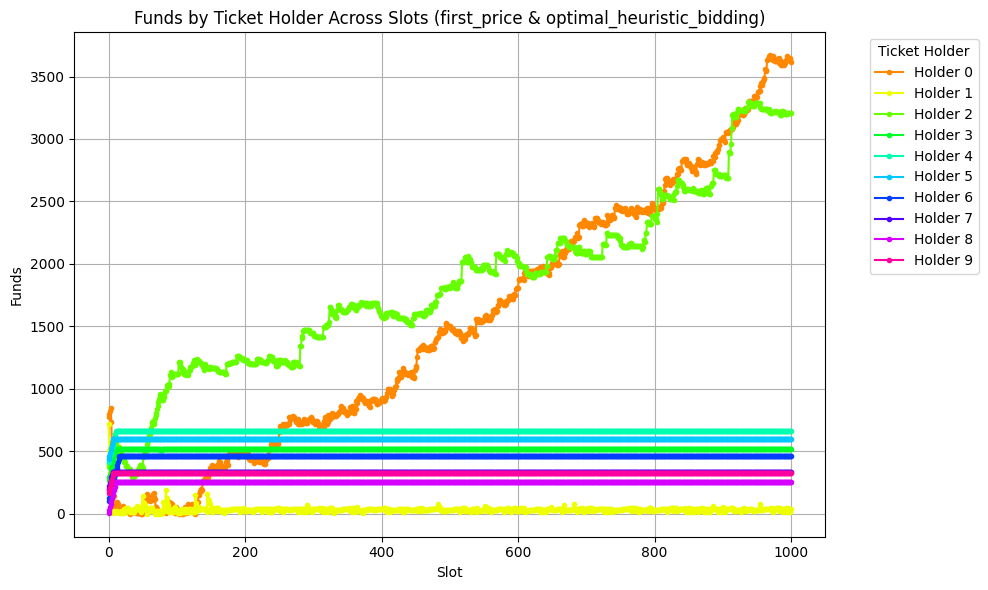

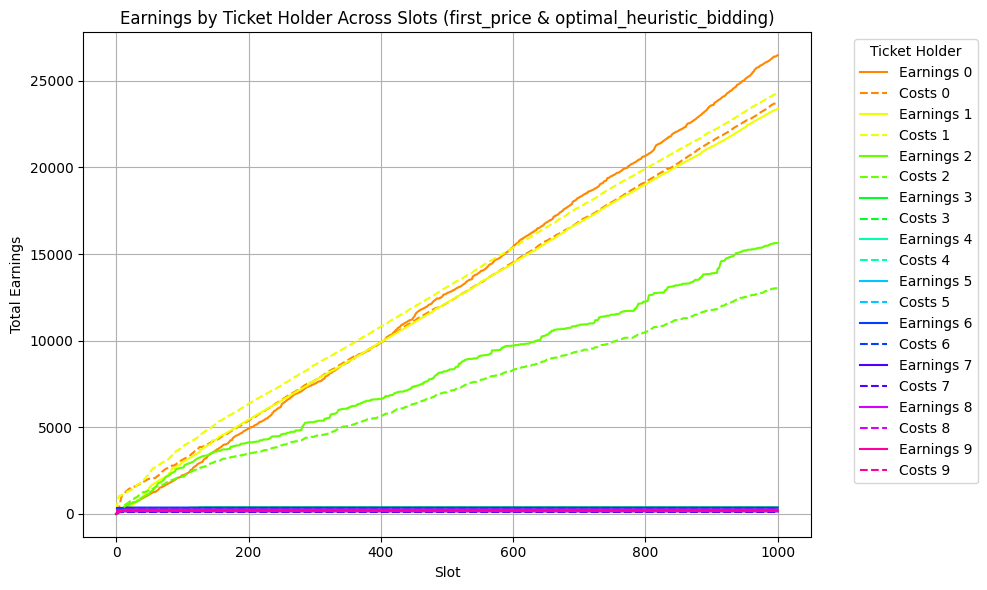

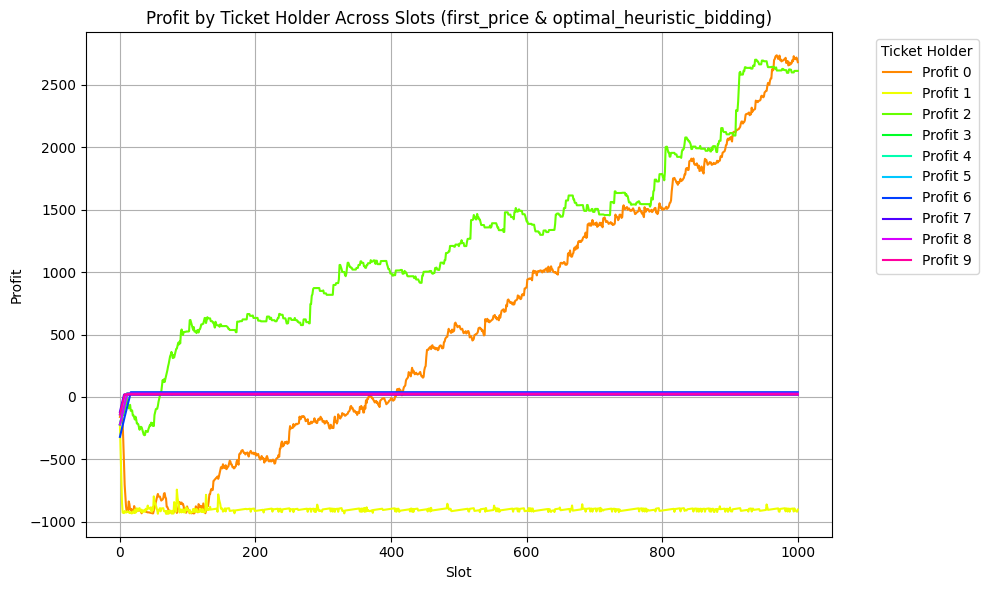

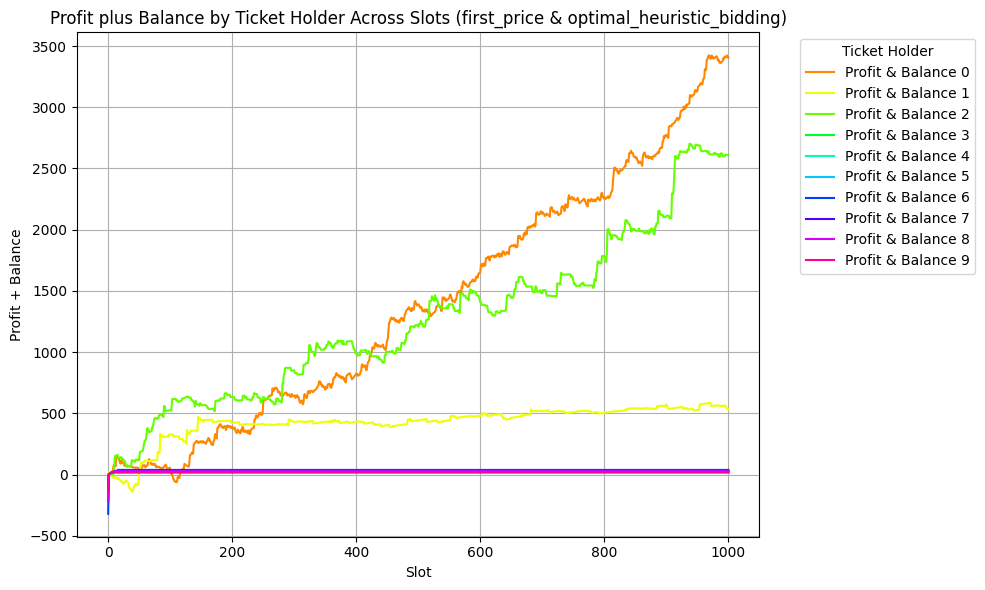

<ipython-input-7-77f787562b4f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['bought_ticket_count'] = reduced_df['tickets'].apply(count_bought_tickets)
<ipython-input-7-77f787562b4f>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['held_ticket_count'] = reduced_df['tickets'].apply(count_held_tickets)


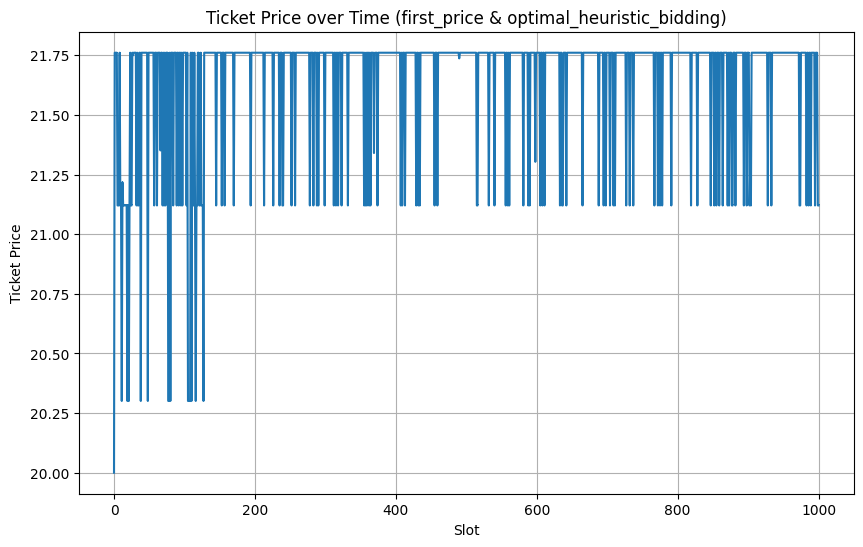

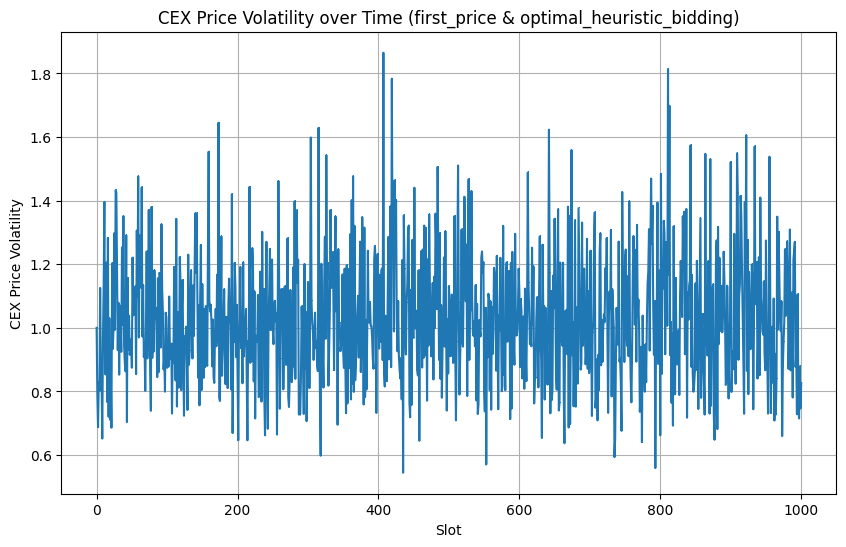

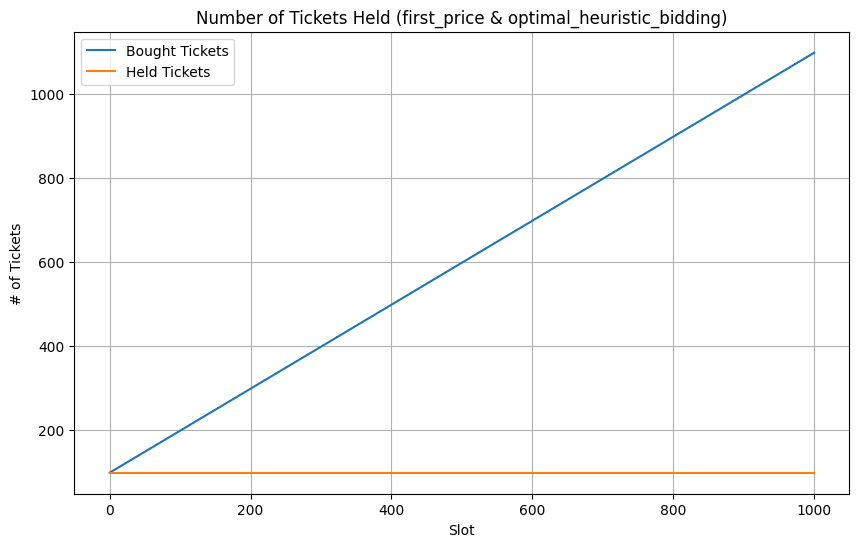

In [7]:
##### Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


# Generate a color palette, one color for each ticket holder, similar to previous plots
colors = sns.color_palette("hsv", n_colors=len(normalized_df['id'].unique()))

# Define the directory if not existing
if not os.path.exists(file_path):
    os.makedirs(file_path)

### Graphic on Funds per Ticket Holder over Time

plt.figure(figsize=(10, 6))

for (name, group), color in zip(normalized_df.groupby('id'), colors):
    # Plot available funds for each ticket holder using the designated color and marker
    plt.plot(group['slot'], group['avail_funds'], marker='.', color=color, label=f"Holder {name}")

plt.title(f"Funds by Ticket Holder Across Slots ({sys_params['selling_mechanism']} & {sys_params['agent_bidding_strategy']})")
plt.xlabel('Slot')
plt.ylabel('Funds')
plt.legend(title='Ticket Holder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend if necessary

file_path_funds_per_th = f"{file_path}/Graphic [1] - Funds per Ticket Holder"
plt.savefig(file_path_funds_per_th)

plt.show()


### Graphic on Earnings & Costs per Ticket Holder over Time

plt.figure(figsize=(10, 6))


for (name, group), color in zip(normalized_df.groupby('id'), colors):
    # Plot earnings with one style
    plt.plot(group['slot'], group['earnings'], color=color, linestyle='-', label=f"Earnings {name}")
    # Plot costs with another style
    plt.plot(group['slot'], group['costs'], color=color, linestyle='--', label=f"Costs {name}")

plt.title(f"Earnings by Ticket Holder Across Slots ({sys_params['selling_mechanism']} & {sys_params['agent_bidding_strategy']})")
plt.xlabel('Slot')
plt.ylabel('Total Earnings')
plt.legend(title='Ticket Holder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend if necessary

file_path_mev_per_th = f"{file_path}/Graphic [2] - Total Earnings and Costs per Ticket Holder"
plt.savefig(file_path_mev_per_th)

plt.show()

#### A chart with the profits per ticket holder

plt.figure(figsize=(10, 6))

for (name, group), color in zip(normalized_df.groupby('id'), colors):
    # Calculate profit for each slot
    profit = group['earnings'] - group['costs']
    # Plot profit with the assigned color
    plt.plot(group['slot'], profit, color=color, linestyle='-', label=f"Profit {name}")

plt.title(f"Profit by Ticket Holder Across Slots ({sys_params['selling_mechanism']} & {sys_params['agent_bidding_strategy']})")
plt.xlabel('Slot')
plt.ylabel('Profit')
plt.legend(title='Ticket Holder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend if necessary

file_path_profits = f"{file_path}/Graphic [3] - Profits per Ticket Holder"
plt.savefig(file_path_profits)

plt.show()

### Grapic of Profits per Ticket holder including the tickets on balance

plt.figure(figsize=(10, 6))

for (name, group), color in zip(normalized_df.groupby('id'), colors):

    profit = group['earnings'] - group['costs']
    profit_and_balance = profit + group['purchase_value_of_unredeemed_tickets']

    # Plot profit with the assigned color
    plt.plot(group['slot'], profit_and_balance, color=color, linestyle='-', label=f"Profit & Balance {name}")

plt.title(f"Profit plus Balance by Ticket Holder Across Slots ({sys_params['selling_mechanism']} & {sys_params['agent_bidding_strategy']})")
plt.xlabel('Slot')
plt.ylabel('Profit + Balance')
plt.legend(title='Ticket Holder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend if necessary

file_path_profits_balance = f"{file_path}/Graphic [4] - Profits plus Balance per Ticket Holder"
plt.savefig(file_path_profits_balance)

plt.show()



### Graphic on Ticket Price over time

plt.figure(figsize=(10, 6))
plt.plot(reduced_df['slot'], reduced_df['ticket_price'], marker=',')
plt.title(f"Ticket Price over Time ({sys_params['selling_mechanism']} & {sys_params['agent_bidding_strategy']})")
plt.xlabel('Slot')
plt.ylabel('Ticket Price')
plt.grid(True)

file_path_price_over_time = f"{file_path}/Graphic [5] - Price over Time"
plt.savefig(file_path_price_over_time)

plt.show

### Graphic on Price Volatility over time

plt.figure(figsize=(10, 6))
plt.plot(reduced_df['slot'], reduced_df['Volatility_per_slot'], marker=',')
plt.title(f"CEX Price Volatility over Time ({sys_params['selling_mechanism']} & {sys_params['agent_bidding_strategy']})")
plt.xlabel('Slot')
plt.ylabel('CEX Price Volatility')
plt.grid(True)

file_path_price_over_time = f"{file_path}/Graphic [6] - CEX Price Volatility over Time"
plt.savefig(file_path_price_over_time)

plt.show


### Show number of tickets held by THs

def count_bought_tickets(tickets):
    return sum(1 for ticket in tickets if ticket.holder_id is not None)

def count_held_tickets(tickets):
    return sum(1 for ticket in tickets if ticket.holder_id is not None and not ticket.redeemed)

reduced_df['bought_ticket_count'] = reduced_df['tickets'].apply(count_bought_tickets)
reduced_df['held_ticket_count'] = reduced_df['tickets'].apply(count_held_tickets)

plt.figure(figsize=(10, 6))
plt.plot(reduced_df['slot'], reduced_df['bought_ticket_count'], label='Bought Tickets', marker=',')
plt.plot(reduced_df['slot'], reduced_df['held_ticket_count'], label='Held Tickets', marker=',')
plt.title(f"Number of Tickets Held ({sys_params['selling_mechanism']} & {sys_params['agent_bidding_strategy']})")
plt.xlabel('Slot')
plt.ylabel('# of Tickets')
plt.legend()
plt.grid(True)

file_path_held_over_time = os.path.join(file_path, "Graphic [7] - Held Tickets over Time.png")
plt.savefig(file_path_held_over_time)

plt.show()

Sum of Slots Won:1000. Should be equal to: 1000 Timesteps


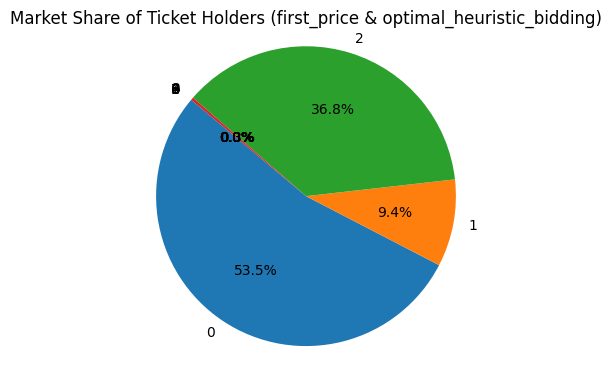

In [8]:
### Calculate Market Shares - last run

reduced_df = results_df.groupby('slot').last().reset_index()
last_ticket_holders = reduced_df['ticket_holder'].iloc[-1]
won_slots_per_holder = [(holder.id, len(holder.won_slots)) for holder in last_ticket_holders]

# Sanity check
sum_of_slots_won = sum(wins for _, wins in won_slots_per_holder)
print(f"Sum of Slots Won:{sum_of_slots_won}. Should be equal to: {TIMESTEPS} Timesteps")  # Debug Print

holder_ids = [holder_id for holder_id, _ in won_slots_per_holder]
won_slots = [wins for _, wins in won_slots_per_holder]

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(won_slots, labels=holder_ids, autopct='%1.1f%%', startangle=140)
plt.title(f"Market Share of Ticket Holders ({sys_params['selling_mechanism']} & {sys_params['agent_bidding_strategy']})")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout(rect=[0, 0, 1, 0.95])
file_path_market_share = os.path.join(file_path, "Graphic [8] - Market Shares.png")
plt.savefig(file_path_market_share)

plt.show()

In [9]:
## Control Print on ticket Holders (can be excluded later)

ticket_holders_df_last_rows.tail(20)
#normalized_df.tail(60)

,run,id,available_funds,MEV_capture_rate,aggressiveness,vola_spec_factor,competitiveness_score,earnings,costs,won_slots,discount_factor,ticket_ids,ticket_count,ticket_count_unredeemed,purchase_value_of_unredeemed_tickets,num_won_slots
80,9,0,3579.604726,0.891500,0.122555,0.917570,0.782242,26595.549227,23949.219817,"[6, 7, 8, 9, 15, 18, 19, 20, 21, 23, 24, 26, 3...",1,"[675, 335, 1045, 357, 969, 595, 538, 302, 292,...",572,30,659.463631,542
81,9,1,23.779910,0.940440,0.143001,0.964064,0.805956,23309.338545,24221.974897,"[1, 2, 3, 4, 12, 17, 31, 32, 33, 34, 35, 37, 3...",1,"[24, 785, 1075, 899, 11, 16, 1054, 1013, 1066,...",157,69,1501.496505,88
82,9,2,3211.405254,0.871967,0.137716,2.164552,0.751884,15829.059989,13214.757146,"[5, 10, 11, 14, 16, 22, 25, 27, 28, 29, 36, 38...",1,"[201, 306, 421, 1060, 243, 851, 642, 407, 805,...",367,0,0.000000,367
83,9,3,577.081501,0.770353,0.109899,1.141310,0.685692,338.575320,253.949888,"[13, 72]",1,"[92, 133]",2,0,0.000000,2
84,9,4,664.155015,0.751175,0.125145,0.990626,0.657169,250.910587,220.000000,[],1,[],0,0,0.000000,0
85,9,5,585.341328,0.774353,0.175288,0.829078,0.638618,163.036129,154.226404,[77],1,[158],1,0,0.000000,1
86,9,6,456.762889,0.781515,0.139612,1.460935,0.672406,354.411277,320.000000,[],1,[],0,0,0.000000,0
87,9,7,336.551991,0.700926,0.171596,1.078780,0.580650,138.071332,120.000000,[],1,[],0,0,0.000000,0
88,9,8,253.000580,0.749966,0.174275,1.571251,0.619265,242.697234,220.000000,[],1,[],0,0,0.000000,0
89,9,9,327.594355,0.606323,0.114274,1.085460,0.537037,160.684567,140.000000,[],1,[],0,0,0.000000,0


### MEV Insights & Analysis

Total MEV available in all runs: 298545.59
Thereof earnings by ticket holders: 672940.36 (225.41 %)
Thereof captured by protocol: 216562.92 (32.18 %)


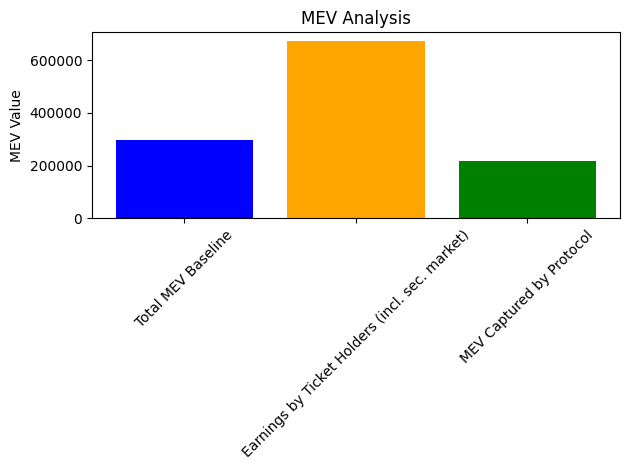

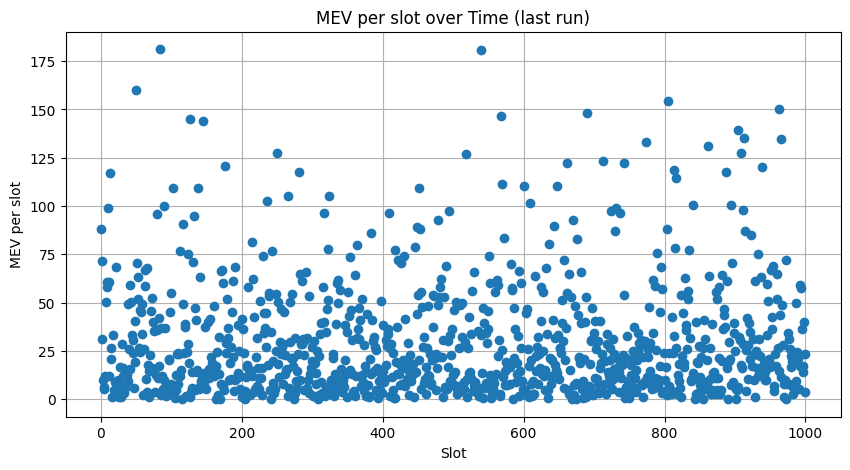

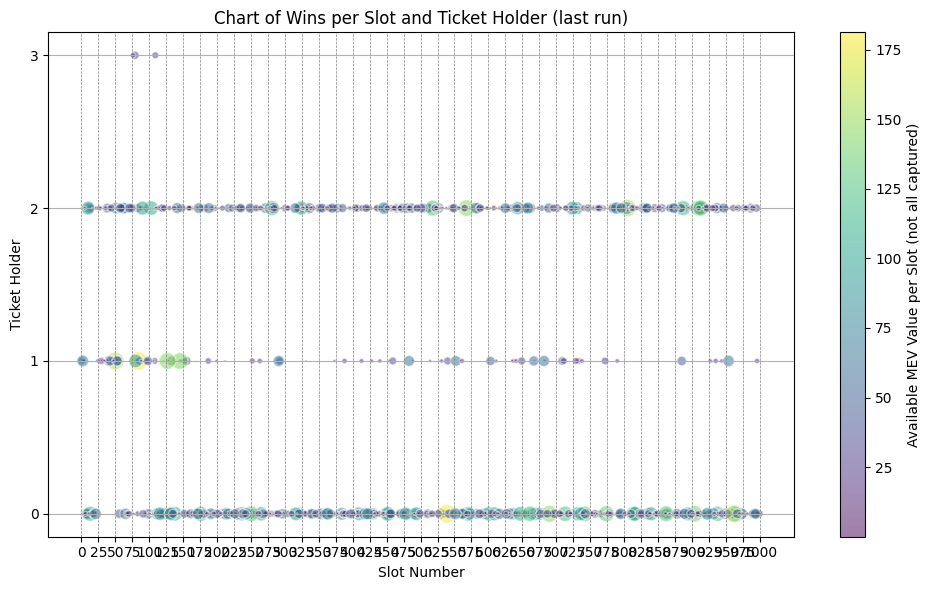

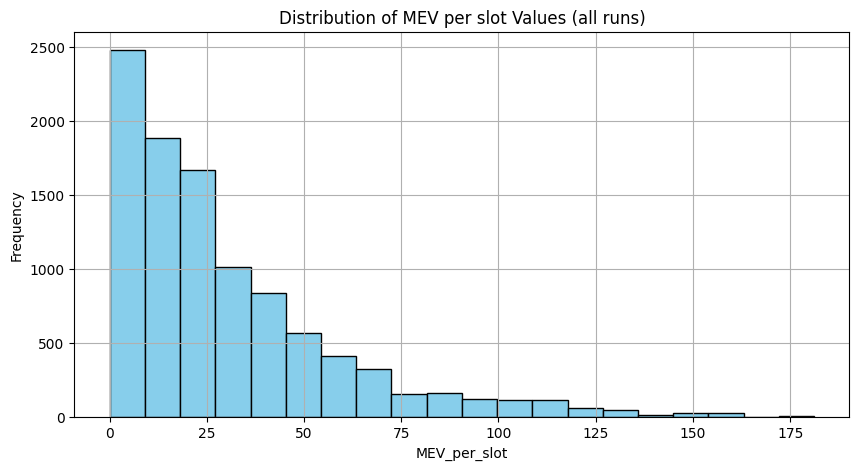

In [10]:
### MEV Analysis

# Data stored for single and multiple runs
max_run = max(all_runs_reduced_df['run'])
reduced_df_mev_all_runs = copy.deepcopy(all_runs_reduced_df)
mev_last_run = copy.deepcopy(all_runs_reduced_df[all_runs_reduced_df['run'] == max_run])

total_MEV_available = sum(reduced_df_mev_all_runs['MEV_per_slot'])
total_earnings_ticket_holders = 0
total_MEV_captured_by_protocol = 0

for run in range(1, max_run + 1):
    run_df = reduced_df_mev_all_runs[reduced_df_mev_all_runs['run'] == run]
    if not run_df.empty:
        total_MEV_captured_by_protocol += run_df['total_MEV_captured'].iloc[-1]
        last_row_ticket_holders = run_df['ticket_holder'].iloc[-1]
        for holder in last_row_ticket_holders:
            total_earnings_ticket_holders += holder.earnings

percentage_protocol_of_ticket_holder = (total_MEV_captured_by_protocol / total_earnings_ticket_holders) * 100
percentage_ticket_holder_of_available = (total_earnings_ticket_holders / total_MEV_available) * 100
percentage_protocol_of_available = (total_MEV_captured_by_protocol / total_MEV_available) * 100

print(f"Total MEV available in all runs: {total_MEV_available:.2f}")
print(f"Thereof earnings by ticket holders: {total_earnings_ticket_holders:.2f} ({percentage_ticket_holder_of_available:.2f} %)")
print(f"Thereof captured by protocol: {total_MEV_captured_by_protocol:.2f} ({percentage_protocol_of_ticket_holder:.2f} %)")

# Plotting

### Chart with the values from above (captured MEV)
labels = ['Total MEV Baseline', 'Earnings by Ticket Holders (incl. sec. market)', 'MEV Captured by Protocol']
values = [total_MEV_available, total_earnings_ticket_holders, total_MEV_captured_by_protocol]

plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.ylabel('MEV Value')
plt.title('MEV Analysis')
plt.xticks(rotation=45)
plt.tight_layout()
file_path_mev_capture = f"{file_path}/Graphic [9] - MEV Capture"
plt.savefig(file_path_mev_capture)
plt.show()

### Chart with MEV over time
plt.figure(figsize=(10, 5))
plt.plot(mev_last_run['slot'], mev_last_run['MEV_per_slot'], marker='o', linestyle='')
plt.xlabel('Slot')
plt.ylabel('MEV per slot')
plt.title('MEV per slot over Time (last run)')
plt.grid(True)
file_path_mev_per_run = f"{file_path}/Graphic [10] - MEV per Slot"
plt.savefig(file_path_mev_per_run)
plt.show()

### MEV per Holder Values
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tickets_last_row_df_excl_nan['assigned_slot'],  # x-axis: Slot numbers
    tickets_last_row_df_excl_nan['holder_id'],  # y-axis: Ticket holder IDs
    s=tickets_last_row_df_excl_nan['MEV_per_slot'],  # Bubble sizes, scaled for better visibility
    alpha=0.5,  # Bubble transparency
    cmap='viridis',  # Color map
    c=tickets_last_row_df_excl_nan['MEV_per_slot'],  # Color of bubbles based on the 'WonValue'
    edgecolors='w',  # White edge color for better visibility
    linewidth=1  # Edge line width
)
# Adding color bar
plt.colorbar(scatter, label='Available MEV Value per Slot (not all captured)')

# Adding labels and title
plt.xlabel('Slot Number')
plt.ylabel('Ticket Holder')
plt.title('Chart of Wins per Slot and Ticket Holder (last run)')
plt.xticks(range(0, tickets_last_row_df_excl_nan['assigned_slot'].max() + 1, 25))
plt.yticks(tickets_last_row_df_excl_nan['holder_id'].unique())  # Set y-ticks to be the ticket holders

# NOTE: Bubble size is based on theoretical MEV per slot (not value captured)

plt.grid(axis='x', which='major', color='grey', linestyle='--', linewidth=0.5)

# Show plot
plt.grid(True)  # Enable grid for easier readability
plt.tight_layout()  # Adjust layout
file_path_won_slots = f"{file_path}/Graphic [11] - MEV per Slot and Holder"
plt.savefig(file_path_won_slots)
plt.show()


### Distribution of the MEV values
plt.figure(figsize=(10, 5))
plt.hist(reduced_df_mev_all_runs['MEV_per_slot'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('MEV_per_slot')
plt.ylabel('Frequency')
plt.title('Distribution of MEV per slot Values (all runs)')
plt.grid(True)
file_path_mev_distr = f"{file_path}/Graphic [12] - Distribution of MEV per Slot"
plt.savefig(file_path_mev_distr)
plt.show()

## Calculate Evaluation Statistics

*Note: All other cells need to be run first*

In [11]:
### Calculate Evaluation Statistics - cells before need to be run first

from calc_statistics import *
import csv


### OBJECTIVES
## 1. Decentralization

print()
print("\033[1mObjectives\033[0m")
print()

# wsph = won_slots_per_holder
prices_df = all_runs_reduced_df[['run','slot', 'epoch', 'ticket_price']]

#### ---------

print("1. Decentralization Measurements")

reduced_df = all_runs_reduced_df
max_run = max(all_runs_reduced_df['run'])
list_largest_market_share_in_per = []
list_nakamoto_coefficient = []
list_hhi = []

print("Individual Runs")
for run in range(1, max_run + 1):
    print(f"Run: {run}")
    run_df = reduced_df[reduced_df['run'] == run]
    won_slots_per_holder = []
    for holder in run_df['ticket_holder'].iloc[-1]:
        won_slots = len(holder.won_slots)
        won_slots_per_holder.append((holder.id, won_slots))

    sum_of_slots_won = sum(wins for _, wins in won_slots_per_holder)

    holder_ids = [holder_id for holder_id, _ in won_slots_per_holder]
    won_slots = [wins for _, wins in won_slots_per_holder]

## 1.1. Market Share largest execution ticket holder / block builder

    highest_won_slots = max(won_slots_per_holder, key=lambda x: x[1])[1]
    largest_market_share = highest_won_slots/sum_of_slots_won
    largest_market_share_in_per = largest_market_share*100
    list_largest_market_share_in_per.append(largest_market_share_in_per)
    print(f"Highest market share: {largest_market_share_in_per} % (Holder: {max(won_slots_per_holder, key=lambda x: x[1])[0]})")

    ## 1.2. Nakamoto-coefficient

    nakamoto_coefficient = calculate_nakamoto_coefficient(won_slots_per_holder)
    list_nakamoto_coefficient.append(nakamoto_coefficient)
    print(f"Nakamoto Coefficient: {nakamoto_coefficient} out of {len(won_slots_per_holder)}")

    ## 1.3. Herfindahl–Hirschman index

    hhi = calculate_hhi(won_slots_per_holder)
    list_hhi.append(hhi)
    print(f"Herfindahl–Hirschman index: {hhi} out of 0 (decentralized) to 10,000.0 (monopoly).")

print("")
print("Cummulated Metrics (avg. over runs)")
print(f"Higehst market Share: {sum(list_largest_market_share_in_per)/len(list_largest_market_share_in_per)}")
print(f"Nakamote Coefficient: {sum(list_nakamoto_coefficient)/len(list_nakamoto_coefficient)}")
print(f"Herfindahl–Hirschman index: {sum(list_hhi)/len(list_hhi)} out of 0 (decentralized) to 10,000.0 (monopoly).")


    ## 2. MEV Capture (Share Value Captured at Protocol)
print("")
print("2. MEV Capture (avg. over runs)")

ppoa = percentage_protocol_of_available
ppoth = percentage_protocol_of_ticket_holder
print(f"Share_Protocol: {ppoa:.2f} % (Share of value captured by the protocol of total MEV available)")
print(f"Share of Protocol from Ticket Holders: {ppoth:.2f} %")

### PRICING BEHAVIOR

print()
print("\033[1mPricing Behavior\033[0m")
print()

## 3. Garman-Klass (GK)  Measure
list_garman_klass_volatility = []
list_variance_of_deltas = []

for run in range(1, max_run+1):
    prices_this_run = prices_df[prices_df['run'] == run]
    gk_volatility = garman_klass_volatility(prices_this_run)
    list_garman_klass_volatility.append(gk_volatility)
    variance_of_deltas = calc_variance_of_deltas(prices_this_run)
    list_variance_of_deltas.append(variance_of_deltas)

gk_volatility_avg = sum(list_garman_klass_volatility)/len(list_garman_klass_volatility)
print(f"3. Garman-Klass Volatility (avg. over {max_run}): {gk_volatility_avg:.3f} (timespan set to one epoch)")

## 4. Var(Delta(P))
var_of_deltas_avg = sum(list_variance_of_deltas)/len(list_variance_of_deltas)
print(f"4. Variance of Deltas (Price Smoothness/Variability): {var_of_deltas_avg:.3f}")

result_text = ["1. Decentralization Measurements",
               f"Higehst market Share: {sum(list_largest_market_share_in_per)/len(list_largest_market_share_in_per)}",
               f"Nakamote Coefficient: {sum(list_nakamoto_coefficient)/len(list_nakamoto_coefficient)}",
               f"Herfindahl–Hirschman index: {sum(list_hhi)/len(list_hhi):.1f} out of 0 (decentralized) to 10,000.0 (monopoly).",
                "2. MEV Capture",
                f"Share_Protocol: {ppoa:.2f} % (Share of value captured by the protocol of total MEV available)",
                f"Share of captured by Protocol from Ticket Holder Revenue (not accurate if secondary market enabled): {ppoth:.2f} %",
                "Pricing Behavior",
                f"3. Garman-Klass Volatility: {gk_volatility_avg:.3f} (timespan set to one epoch)",
                f"4. Variance of Deltas (Price Smoothness/Variability): {var_of_deltas_avg:.3f}",
                f"All metrics are averages over {max_run} runs"
                ]


file_path_objectives = f"{file_path}/Evaluation - Objectives.csv"
with open(file_path_objectives, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Results for Objectives of Simulation"])
    writer.writerows([[line] for line in result_text])

print("")
print(f"Results saved under: {file_path_objectives}")


Objectives

1. Decentralization Measurements
Individual Runs
Run: 1
Highest market share: 56.99999999999999 % (Holder: 0)
Nakamoto Coefficient: 1 out of 10
Herfindahl–Hirschman index: 4545.82 out of 0 (decentralized) to 10,000.0 (monopoly).
Run: 2
Highest market share: 56.89999999999999 % (Holder: 0)
Nakamoto Coefficient: 1 out of 10
Herfindahl–Hirschman index: 4541.48 out of 0 (decentralized) to 10,000.0 (monopoly).
Run: 3
Highest market share: 56.10000000000001 % (Holder: 0)
Nakamoto Coefficient: 1 out of 10
Herfindahl–Hirschman index: 4439.340000000001 out of 0 (decentralized) to 10,000.0 (monopoly).
Run: 4
Highest market share: 56.599999999999994 % (Holder: 0)
Nakamoto Coefficient: 1 out of 10
Herfindahl–Hirschman index: 4506.62 out of 0 (decentralized) to 10,000.0 (monopoly).
Run: 5
Highest market share: 56.599999999999994 % (Holder: 0)
Nakamoto Coefficient: 1 out of 10
Herfindahl–Hirschman index: 4501.219999999999 out of 0 (decentralized) to 10,000.0 (monopoly).
Run: 6
Highest m